In [ ]:
from PIL import Image
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
import zipfile
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/PVdetection.zip',compression=zipfile.ZIP_LZMA)
zf.extractall('/content/')
zf.close()

In [ ]:
folders_path = '/content/PVdetection/PV01/PV01/'
folders = os.listdir(folders_path)
dataset = {}
for folder in folders:
  files = os.listdir(folders_path+folder)
  for file_name in files:
    if not file_name.find('_label') > -1:
      img = Image.open(folders_path+folder+'/'+file_name)
      img = np.array(img)
      file_name = file_name.replace('.bmp','')
      if not file_name in dataset.keys():
        dataset[file_name] = {}
      dataset[file_name]['image'] = img
    else:
      mask = Image.open(folders_path+folder+'/'+file_name)
      mask = np.array(mask)
      mask[mask == mask.max()] = 1
      file_name = file_name.replace('_label.bmp','')
      if not file_name in dataset.keys():
        dataset[file_name] = {}
      dataset[file_name]['mask'] = mask

In [ ]:
id2label = {0:"no PV",1:"PV"}
label2id = {"no PV":0,"PV":1}

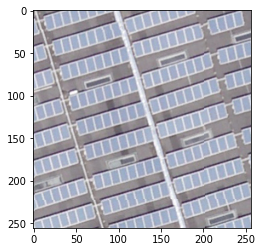

In [ ]:
for key, value in dataset.items():
  plt.imshow(value['image'])
  break

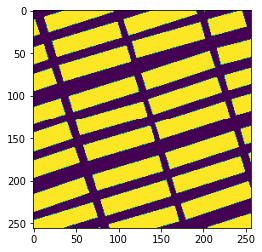

In [ ]:
for key, value in dataset.items():
  plt.imshow(value['mask'])
  break

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, images,masks, batch_size=8, image_size=256):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, index):
        image = self.images[index]
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = self.masks[index]
        mask = cv2.resize(mask,(self.image_size,self.image_size))

        ## Normalizaing
        image = image/255.0
        mask = mask

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images):
            self.batch_size = len(self.images) - index*self.batch_size

        indexes = range(index*self.batch_size,(index+1)*self.batch_size)

        image = []
        mask  = []

        for i in indexes:
            _img, _mask = self.__load__(i)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images)/float(self.batch_size)))

In [ ]:
image_size = 256
epochs = 100
batch_size = 2

## Validation Data Size
val_data_size = 10

train_range = np.random.randint(0,len(dataset.keys()),size = int(0.8*len(dataset.keys())))
test_range = []
for i in range(len(dataset.keys())):
  if i not in train_range:
    test_range.append(i)

In [ ]:
train_images = []
train_masks = []
for i in train_range:
  value = list(dataset.values())[i]
  train_images.append(value['image'])
  train_masks.append(value['mask'])

test_images = []
test_masks = []
for i in test_range:
  value = list(dataset.values())[i]
  test_images.append(value['image'])
  test_masks.append(value['mask'])

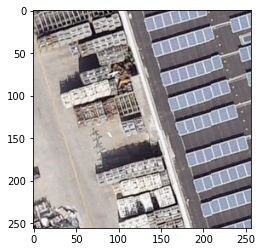

In [ ]:
for img in train_images:
  plt.imshow(img)
  break

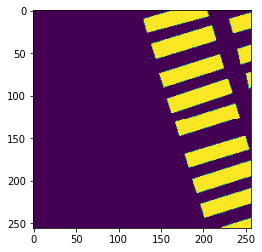

In [ ]:
for img in train_masks:
  plt.imshow(img)
  break

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet(image_size):
    f = [32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #256 -> 128
    c2, p2 = down_block(p1, f[1]) #128 -> 64
    c3, p3 = down_block(p2, f[2]) #64 -> 32
    c4, p4 = down_block(p3, f[3]) #32->16

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #16 -> 32
    u2 = up_block(u1, c3, f[2]) #32 -> 64
    u3 = up_block(u2, c2, f[1]) #64 -> 128
    u4 = up_block(u3, c1, f[0]) #128 -> 256

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet(256)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
train_gen = DataGen(train_images, train_masks, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(test_images, test_masks, image_size=image_size, batch_size=batch_size)

train_steps = len(train_images)//batch_size
valid_steps = len(test_masks)//batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,
                    epochs=epochs,callbacks=[callback])

<ipython-input-15-d08434b46f01>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/20
258/258 [==============================] - 33s 58ms/step - loss: 0.5587 - acc: 0.7137 - val_loss: 0.6312 - val_acc: 0.6719
Epoch 2/20
258/258 [==============================] - 14s 55ms/step - loss: 0.6060 - acc: 0.7176 - val_loss: 0.6508 - val_acc: 0.6341
Epoch 3/20
258/258 [==============================] - 13s 52ms/step - loss: 0.6124 - acc: 0.7176 - val_loss: 0.6631 - val_acc: 0.6341
Epoch 4/20
258/258 [==============================] - 14s 53ms/step - loss: 0.6451 - acc: 0.7174 - val_loss: 0.6191 - val_acc: 0.6341
Epoch 5/20
258/258 [==============================] - 14s 53ms/step - loss: 0.6160 - acc: 0.7176 - val_loss: 0.6639 - val_acc: 0.6341
Epoch 6/20
258/258 [==============================] - 13s 52ms/step - loss: 0.6060 - acc: 0.7169 - val_loss: 0.6708 - val_acc: 0.6341
Epoch 7/20
258/258 [==============================] - 13s 52ms/step - loss: 0.5890 - acc: 0.7173 - val_loss: 0.6284 - val_acc: 0.6341
Epoch 8/20
258/258 [==============================] - 14s 53ms

In [ ]:
model.save("/content/drive/MyDrive/Unet/")

In [ ]:

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 233ms/step


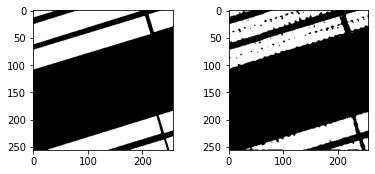

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")